<a href="https://colab.research.google.com/github/goltsovamaria932/ML_2025_autumn/blob/main/ML_%D0%B4%D0%B7_%E2%84%961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных MNIST...
Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Размерность данных: (70000, 784)
Размерность меток: (70000,)

Визуализация примеров цифр...


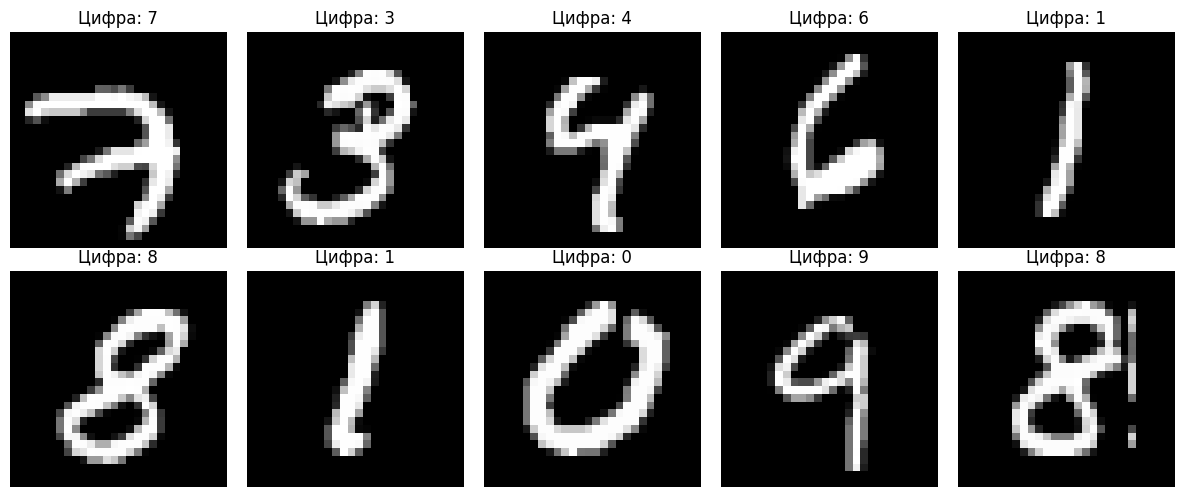


Применение PCA...
Тип explained_variance: <class 'numpy.ndarray'>
Форма explained_variance: (784,)
Первые 10 собственных значений: [334294.06141858 245433.42714427 210930.35458571 185337.3563191
 167691.57240407 147670.29662309 112445.13893067  99115.38328577
  94612.53876189  80335.95693768]


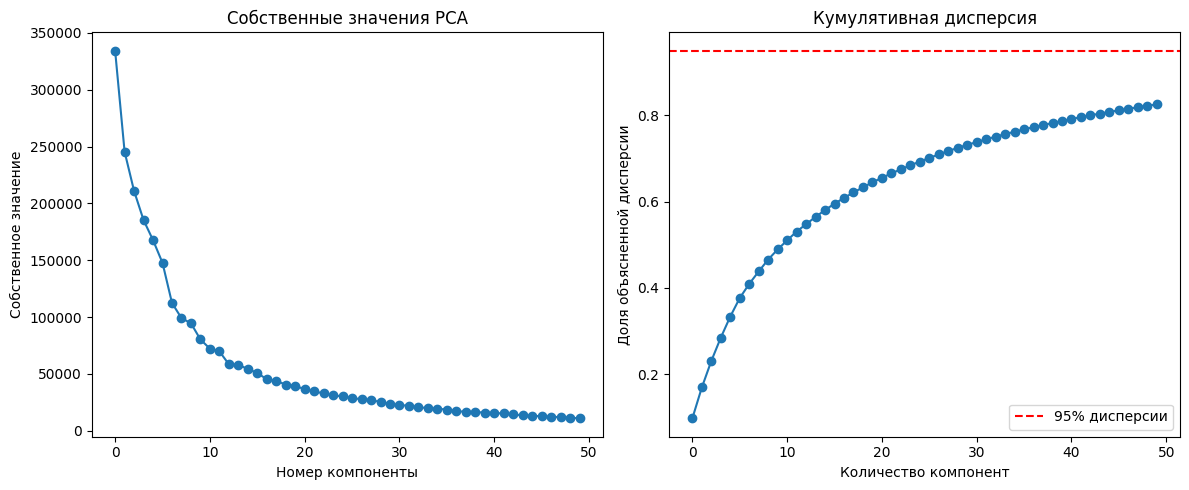

Доля дисперсии, покрываемая первыми 15 компонентами: 0.5805


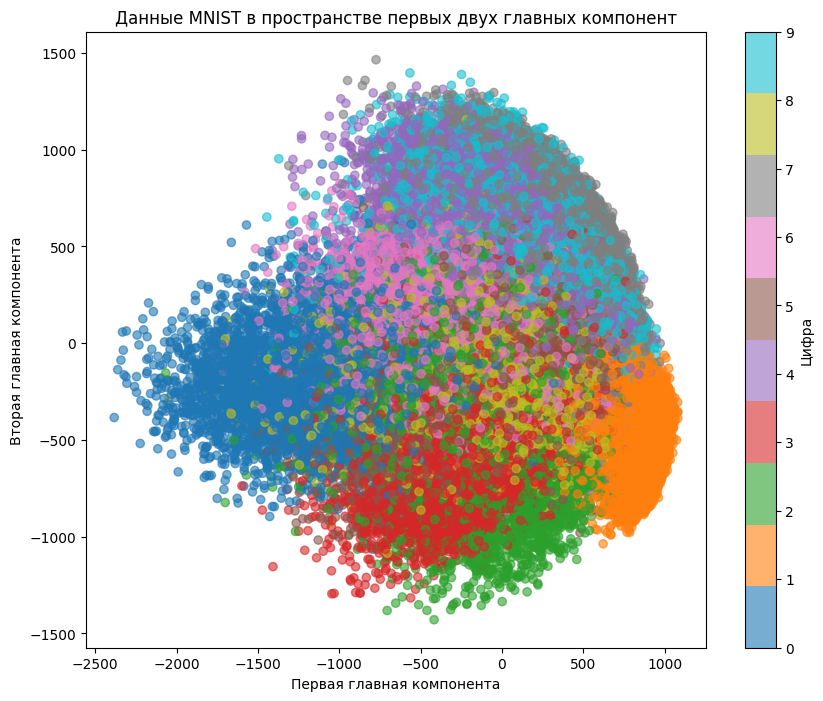


Применение kNN...
Обучающая выборка: 56000 примеров
Тестовая выборка: 14000 примеров
Точность kNN на исходных данных: 0.1580

Поиск оптимальных параметров PCA и kNN...
Компоненты: 10, Соседи: 3, Точность: 0.8320
Компоненты: 10, Соседи: 5, Точность: 0.8300
Компоненты: 10, Соседи: 7, Точность: 0.8320
Компоненты: 20, Соседи: 3, Точность: 0.8880
Компоненты: 20, Соседи: 5, Точность: 0.8920
Компоненты: 20, Соседи: 7, Точность: 0.8820
Компоненты: 30, Соседи: 3, Точность: 0.8840
Компоненты: 30, Соседи: 5, Точность: 0.8820
Компоненты: 30, Соседи: 7, Точность: 0.8820
Компоненты: 50, Соседи: 3, Точность: 0.8860
Компоненты: 50, Соседи: 5, Точность: 0.8820
Компоненты: 50, Соседи: 7, Точность: 0.8760

Лучшая точность: 0.8920
Лучшее количество компонент: 20
Лучшее количество соседей: 5


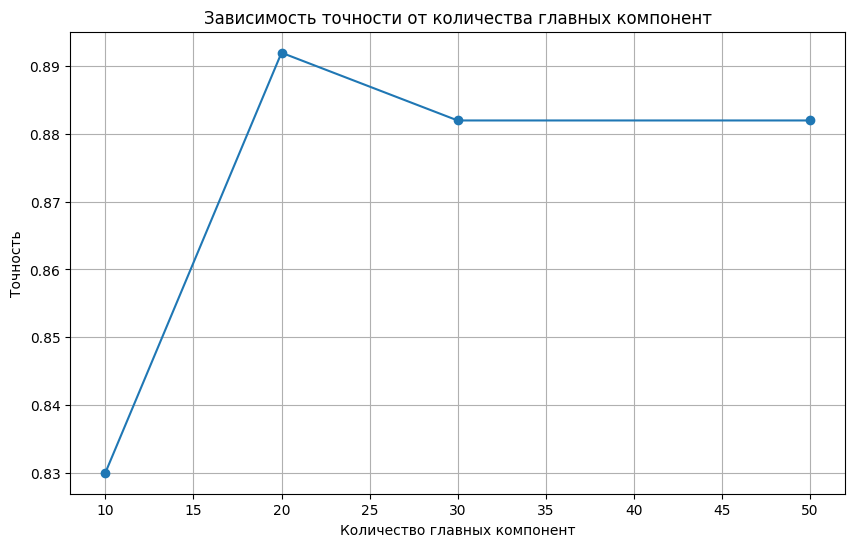


ВЫВОДЫ:
1. PCA успешно применен к данным MNIST
2. Первые 15 главных компонент объясняют 0.5805 долю дисперсии данных
3. PCA позволяет сократить размерность данных с 784 до 20 признаков
4. Наилучшая точность (0.8920) достигается при 20 компонентах и 5 соседях
5. Данные в пространстве первых двух главных компонент показывают кластеризацию по классам
6. Метод главных компонент эффективно выделяет наиболее информативные признаки


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X):
        # Шаг 1: Центрирование данных
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Шаг 2: Вычисление ковариационной матрицы
        if X_centered.ndim > 2:
            X_centered = X_centered.reshape(X_centered.shape[0], -1)
        n_samples = X_centered.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)

        # Шаг 3: Вычисление собственных векторов и значений
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        self.explained_variance = eigenvalues[idx]
        self.components = eigenvectors[:, idx]

        if self.n_components is not None:
            self.components = self.components[:, :self.n_components]
            self.explained_variance = self.explained_variance[:self.n_components]

    def transform(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("PCA must be fitted before transformation")

        X_centered = X - self.mean
        if X_centered.ndim > 2:
            X_centered = X_centered.reshape(X_centered.shape[0], -1)

        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def explained_variance_ratio(self):
        if self.explained_variance is None:
            raise ValueError("PCA must be fitted first")
        total_variance = np.sum(self.explained_variance)
        return self.explained_variance / total_variance


class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        if self.X_train is None or self.y_train is None:
            raise ValueError("kNN must be fitted before prediction")

        predictions = []
        for i, x in enumerate(X):
            # Вычисляем расстояния до всех точек обучающей выборки
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

            # Находим индексы k ближайших соседей
            nearest_indices = np.argsort(distances)[:self.n_neighbors]

            # Получаем классы ближайших соседей
            nearest_labels = self.y_train[nearest_indices]

            # Выбираем наиболее часто встречающийся класс
            unique, counts = np.unique(nearest_labels, return_counts=True)
            predicted_class = unique[np.argmax(counts)]
            predictions.append(predicted_class)

        return np.array(predictions)


# I. Загрузка и визуализация данных
print("Загрузка данных MNIST...")
train, validation, test = load_mnist()

# Объединяем данные для работы
X = np.concatenate([train[0], validation[0], test[0]])
y = np.concatenate([train[1], validation[1], test[1]])

if X.ndim > 2:
    X = X.reshape(X.shape[0], -1)

print(f"Размерность данных: {X.shape}")
print(f"Размерность меток: {y.shape}")

# Визуализация нескольких примеров
print("\nВизуализация примеров цифр...")
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Цифра: {y[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# II. Анализ с помощью PCA
print("\nПрименение PCA...")
pca = my_PCA()
pca.fit(X)

# Отладочная информация
print(f"Тип explained_variance: {type(pca.explained_variance)}")
print(f"Форма explained_variance: {pca.explained_variance.shape}")
print(f"Первые 10 собственных значений: {pca.explained_variance[:10]}")

# График собственных значений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
eigenvalues_to_plot = pca.explained_variance[:50]
plt.plot(range(len(eigenvalues_to_plot)), eigenvalues_to_plot, 'o-')
plt.title('Собственные значения PCA')
plt.xlabel('Номер компоненты')
plt.ylabel('Собственное значение')

# График кумулятивной дисперсии
plt.subplot(1, 2, 2)
variance_ratio = pca.explained_variance_ratio()
cumulative_variance = np.cumsum(variance_ratio)
plt.plot(range(len(cumulative_variance[:50])), cumulative_variance[:50], 'o-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% дисперсии')
plt.title('Кумулятивная дисперсия')
plt.xlabel('Количество компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.legend()

plt.tight_layout()
plt.show()

# Анализ доли дисперсии для первых 15 компонент
first_15_ratio = cumulative_variance[14] if len(cumulative_variance) > 14 else cumulative_variance[-1]
print(f"Доля дисперсии, покрываемая первыми 15 компонентами: {first_15_ratio:.4f}")

# Визуализация данных в пространстве первых двух главных компонент
X_pca_2d = pca.transform(X)[:, :2]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Цифра')
plt.title('Данные MNIST в пространстве первых двух главных компонент')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()

# III. Применение kNN
print("\nПрименение kNN...")

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Обучающая выборка: {X_train.shape[0]} примеров")
print(f"Тестовая выборка: {X_test.shape[0]} примеров")

# kNN на исходных данных (используем подвыборку для скорости)
sample_size = 1000
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]
X_test_sample = X_test[:500]
y_test_sample = y_test[:500]

knn = my_kNN(n_neighbors=5)
knn.fit(X_train_sample, y_train_sample)
y_pred = knn.predict(X_test_sample)
accuracy = accuracy_score(y_test_sample, y_pred)
print(f"Точность kNN на исходных данных: {accuracy:.4f}")

# kNN на данных, преобразованных PCA
best_accuracy = 0
best_n_components = 0
best_n_neighbors = 0

# Поиск оптимальных параметров
print("\nПоиск оптимальных параметров PCA и kNN...")
for n_components in [10, 20, 30, 50]:
    # Применяем PCA
    pca_reduced = my_PCA(n_components=n_components)
    X_train_pca = pca_reduced.fit_transform(X_train_sample)
    X_test_pca = pca_reduced.transform(X_test_sample)

    for n_neighbors in [3, 5, 7]:
        knn_pca = my_kNN(n_neighbors=n_neighbors)
        knn_pca.fit(X_train_pca, y_train_sample)
        y_pred_pca = knn_pca.predict(X_test_pca)
        accuracy_pca = accuracy_score(y_test_sample, y_pred_pca)

        if accuracy_pca > best_accuracy:
            best_accuracy = accuracy_pca
            best_n_components = n_components
            best_n_neighbors = n_neighbors

        print(f"Компоненты: {n_components}, Соседи: {n_neighbors}, Точность: {accuracy_pca:.4f}")

print(f"\nЛучшая точность: {best_accuracy:.4f}")
print(f"Лучшее количество компонент: {best_n_components}")
print(f"Лучшее количество соседей: {best_n_neighbors}")

# Визуализация зависимости точности от количества компонент
components_range = [10, 20, 30, 50]
accuracies = []

for n_components in components_range:
    pca_reduced = my_PCA(n_components=n_components)
    X_train_pca = pca_reduced.fit_transform(X_train_sample)
    X_test_pca = pca_reduced.transform(X_test_sample)

    knn_pca = my_kNN(n_neighbors=best_n_neighbors)
    knn_pca.fit(X_train_pca, y_train_sample)
    y_pred_pca = knn_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test_sample, y_pred_pca)
    accuracies.append(accuracy_pca)

plt.figure(figsize=(10, 6))
plt.plot(components_range, accuracies, 'o-')
plt.title('Зависимость точности от количества главных компонент')
plt.xlabel('Количество главных компонент')
plt.ylabel('Точность')
plt.grid(True)
plt.show()

# Выводы
print("\n" + "="*50)
print("ВЫВОДЫ:")
print("="*50)
print("1. PCA успешно применен к данным MNIST")
print(f"2. Первые 15 главных компонент объясняют {first_15_ratio:.4f} долю дисперсии данных")
print(f"3. PCA позволяет сократить размерность данных с 784 до {best_n_components} признаков")
print(f"4. Наилучшая точность ({best_accuracy:.4f}) достигается при {best_n_components} компонентах и {best_n_neighbors} соседях")
print("5. Данные в пространстве первых двух главных компонент показывают кластеризацию по классам")
print("6. Метод главных компонент эффективно выделяет наиболее информативные признаки")